<a href="https://colab.research.google.com/github/pvdklei/modelsmakemodels/blob/master/sebas/report_notebooks/autoencoder_denoising_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries and packages

import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import utils
import train
import importlib
import visual_tools as vt
from skimage.util import random_noise


In [2]:
# define image loaders

def loaders():
    traintransform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Resize(128),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    testtransform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Resize(128),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    batch_size = 32
    num_workers = 2

    trainset = datasets.CIFAR10("/data/cifar10/train", train=True, transform=traintransform, download=True)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    testset = datasets.CIFAR10("/data/cifar10/test", train=False, transform=testtransform, download=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    return trainloader, testloader

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


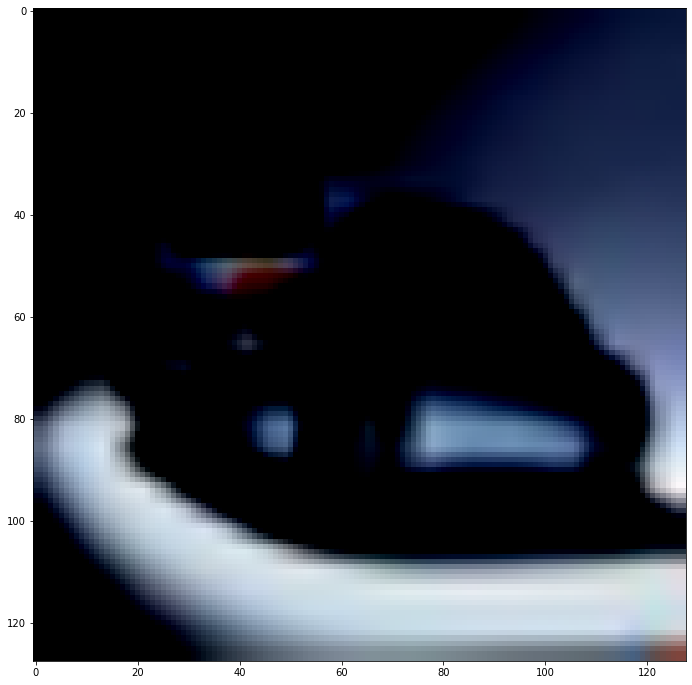

In [3]:
# visualize data

trainloader, _ = loaders()
images, labels = next(iter(trainloader))
vt.show_image(images[0])

In [4]:
# create 2 autoencoders with 2 convolutional layers

encoder = nn.Sequential(nn.Conv2d(3,64, kernel_size=4, stride = 2, padding = 1,),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size = 4, stride = 2),
                        nn.Conv2d(64,64, kernel_size=4, stride = 2, padding = 1,),
                        nn.ReLU())
decoder = nn.Sequential(nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1),
                        nn.ReLU(),
                        nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
                        transforms.Resize(128))

model1 = nn.Sequential(encoder, decoder)
model2 = nn.Sequential(encoder, decoder)
print(model1)
model1(images).shape

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
  )
  (1): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Resize(size=128, interpolation=PIL.Image.BILINEAR)
  )
)


torch.Size([32, 3, 128, 128])

In [ ]:
# create 2 autoencoders with 3 convolutional layers

encoder1 = nn.Sequential(nn.Conv2d(3,64, kernel_size=4, stride = 2, padding = 1,),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size = 4, stride = 2),
                        nn.Conv2d(64,192, kernel_size=4, stride = 2, padding = 1,),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size = 4, stride = 2),
                        nn.Conv2d(192,192, kernel_size=4, stride = 2, padding = 1,),
                        nn.ReLU())

decoder1 = nn.Sequential(nn.ConvTranspose2d(192, 192, 4, stride=2, padding=1),
                        nn.ReLU(),
                        nn.ConvTranspose2d(192, 64, 4, stride=2, padding=1),
                        nn.ReLU(),
                        nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
                        transforms.Resize(128))

model3 = nn.Sequential(encoder1, decoder1)
model4 = nn.Sequential(encoder1, decoder1)
print(model3)
model3(images).shape

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (1): Sequential(
    (0): ConvTranspose2d(192, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(192, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Resize(size=128, interpolation=PIL.Image.BILINEAR)
  )
)


torch.Size([32, 3, 128, 128])

In [6]:
# create trainings

training1 = train.Training(autotrain=True)
training2 = train.Training(autotrain=True)
training3 = train.Training(autotrain=True)
training4 = train.Training(autotrain=True)
assert len(training1.train_losses) == 0
assert len(training2.train_losses) == 0
assert len(training3.train_losses) == 0
assert len(training4.train_losses) == 0

In [ ]:
# train gaussian denoising on 2 layered autoencoder

training1.denoise_train(model=model1,
               loaders=loaders,
               optimizer=optim.Adam(params=model1.parameters(), lr=0.001),
               criterion=nn.MSELoss(), noise_type = 'gaussian',
               epochs=6,
               reload_=False)

Files already downloaded and verified
Files already downloaded and verified
Training on:  cuda
New epoch: 0
Validation loss: 0.242
Training loss: 0.015
New epoch: 1
Validation loss: 0.011
Training loss: 0.01
New epoch: 2
Validation loss: 0.01
Training loss: 0.01
New epoch: 3
Validation loss: 0.009
Training loss: 0.009
New epoch: 4
Validation loss: 0.009
Training loss: 0.009
New epoch: 5
Validation loss: 0.009
Training loss: 0.009


In [7]:
# train speckle denoising on 2 layered autoencoder

training2.denoise_train(model=model2,
               loaders=loaders,
               optimizer=optim.Adam(params=model2.parameters(), lr=0.001),
               criterion=nn.MSELoss(), noise_type = 'speckle',
               epochs=10,
               reload_=False)

Files already downloaded and verified
Files already downloaded and verified
Training on:  cuda
New epoch: 0
Validation loss: 0.241
Training loss: 0.014
New epoch: 1
Validation loss: 0.01
Training loss: 0.009
New epoch: 2
Validation loss: 0.009
Training loss: 0.009
New epoch: 3
Validation loss: 0.008
Training loss: 0.008
New epoch: 4
Validation loss: 0.008
Training loss: 0.008
New epoch: 5
Validation loss: 0.008
Training loss: 0.008
New epoch: 6
Validation loss: 0.008
Training loss: 0.008
New epoch: 7
Validation loss: 0.007
Training loss: 0.008
New epoch: 8
Validation loss: 0.007
Training loss: 0.007
New epoch: 9
Validation loss: 0.008
Training loss: 0.007


In [ ]:
# train gaussian denoising on 3 layered autoencoder

training3.denoise_train(model=model3,
               loaders=loaders,
               optimizer=optim.Adam(params=model3.parameters(), lr=0.001),
               criterion=nn.MSELoss(), noise_type = 'gaussian',
               epochs=2,
               reload_=False)

Files already downloaded and verified
Files already downloaded and verified
Training on:  cuda
New epoch: 0
Validation loss: 0.03
Training loss: 0.028
New epoch: 1
Validation loss: 0.025
Training loss: 0.024


In [ ]:
# train speckle denoising on 3 layered autoencoder

training3.denoise_train(model=model4,
               loaders=loaders,
               optimizer=optim.Adam(params=model4.parameters(), lr=0.001),
               criterion=nn.MSELoss(), noise_type = 'speckle',
               epochs=1,
               reload_=False)

Files already downloaded and verified
Files already downloaded and verified
Training on:  cuda
New epoch: 0
Validation loss: 0.023
Training loss: 0.022


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


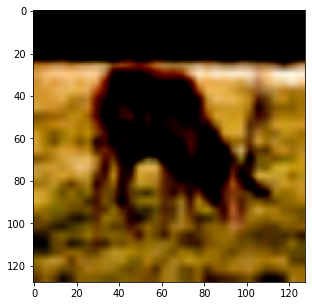

In [ ]:
# prepare images to be shown

im = images[0]
model1 = model1.to('cpu')
model2 = model2.to('cpu')
model3 = model3.to('cpu')
model4 = model4.to('cpu')
im1 = model1(images)
im2 = model2(images)
im3 = model3(images)
im4 = model4(images)

vt.show_image(im, (5,5))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


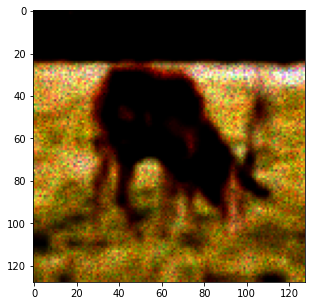

In [ ]:
# show image with gaussian noise

noise_img1 = random_noise(images, mode='gaussian', mean=0, var=0.05, clip=True)
noise_img1 = torch.Tensor(noise_img)
vt.show_image(noise_img1[0], (5,5))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


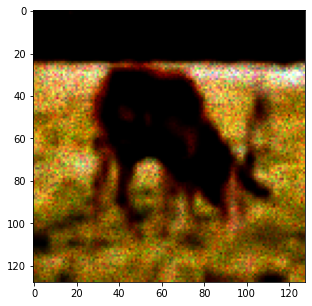

In [ ]:
# show image with speckle noise

noise_img = random_noise(images, mode='speckle', mean=0, var=0.05, clip=True)
noise_img = torch.Tensor(noise_img)
vt.show_image(noise_img[0], (5,5))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


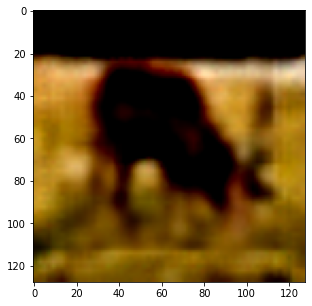

In [ ]:
# show 2 layered denoising model on gaussian noise

vt.show_image(im1[0], (5,5))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


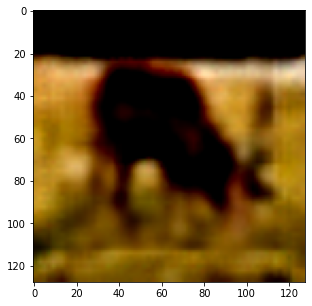

In [ ]:
# show 2 layered denoising model on speckle noise

vt.show_image(im2[0], (5,5))

The MSE loss is:  0.008867832832038403


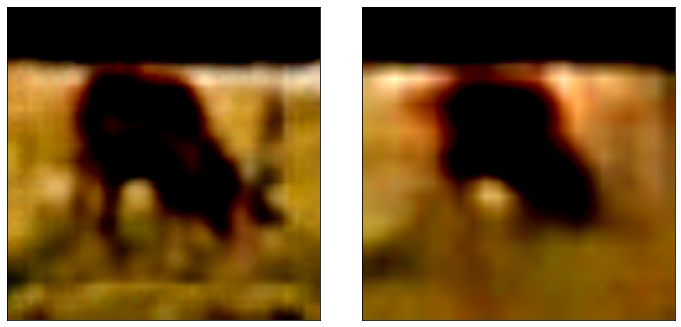





The MSE loss is:  0.00011663909390335903


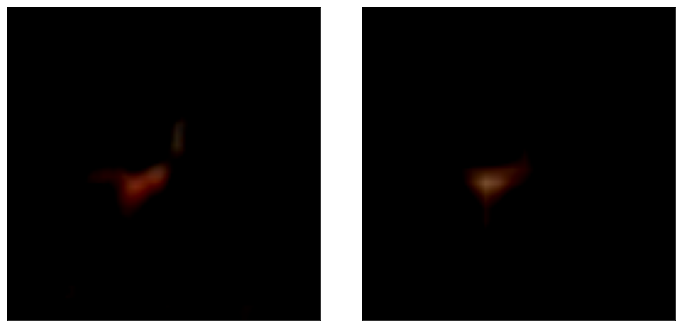





The MSE loss is:  0.001374506508000195


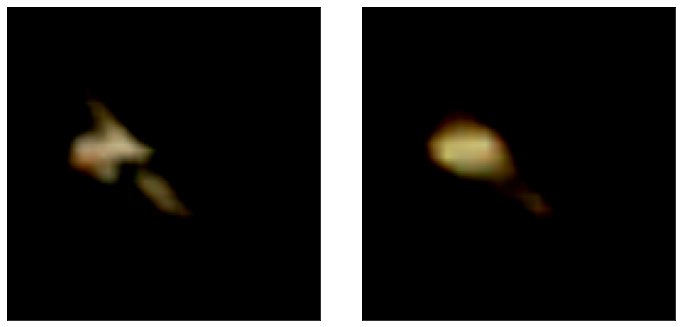





The MSE loss is:  0.003849669126793742


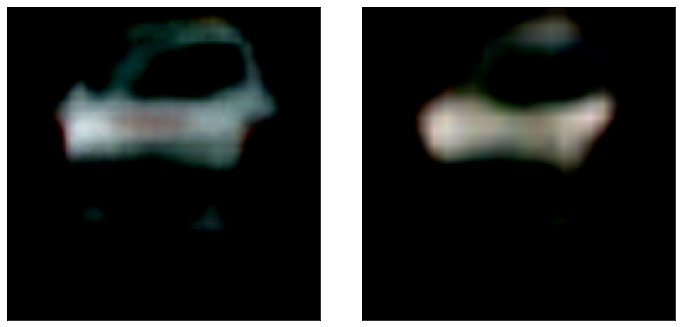





The MSE loss is:  0.004568419884890318


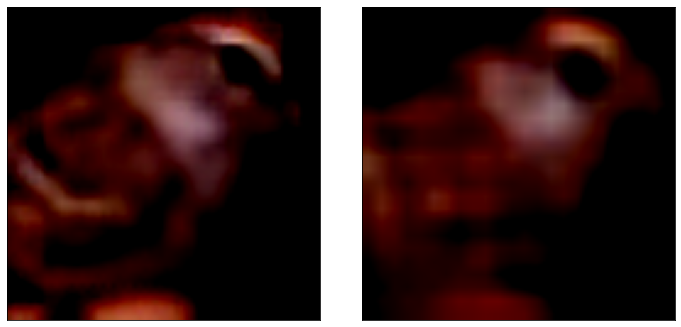





The MSE loss is:  0.004284340422600508


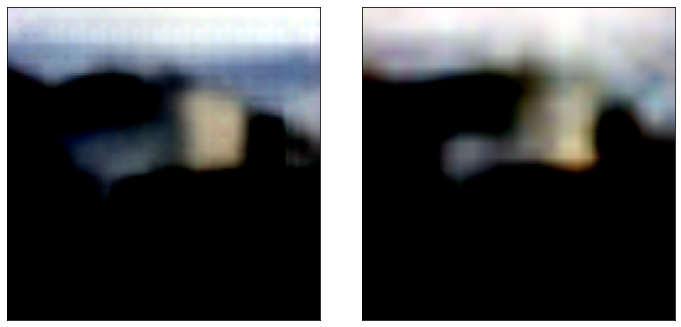





The MSE loss is:  0.007027890998870134


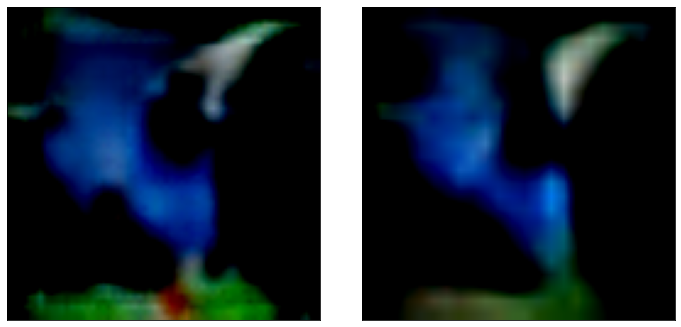





The MSE loss is:  0.007502982392907143


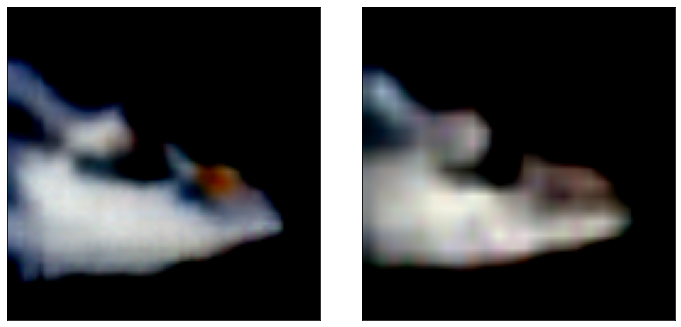





The MSE loss is:  0.0004201786359772086


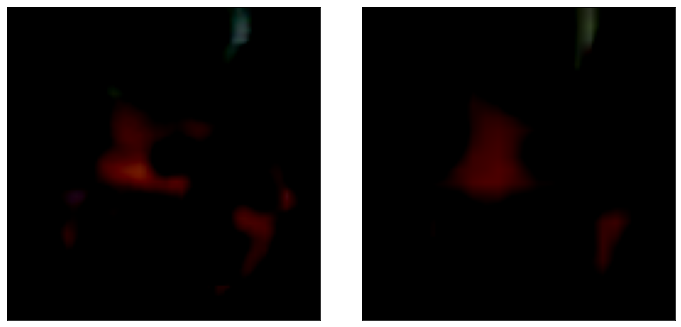





The MSE loss is:  0.006940742954611778


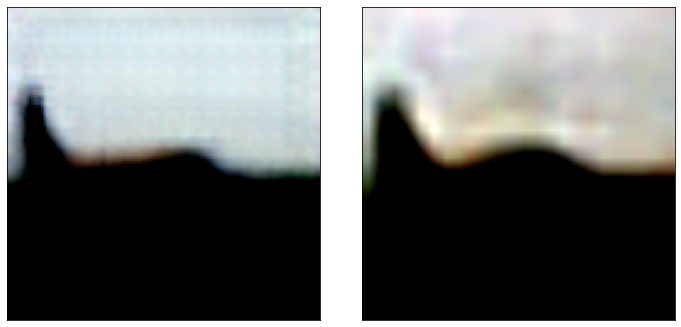





The MSE loss is:  0.004209245555102825


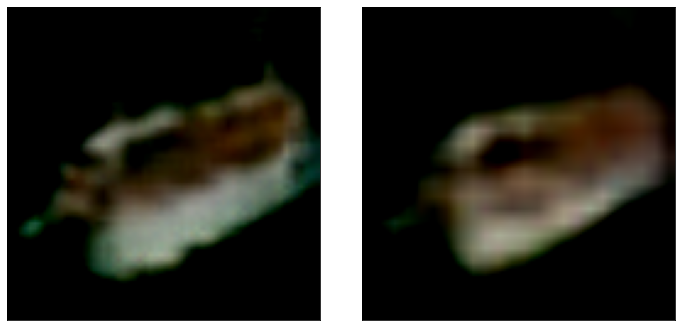





The MSE loss is:  0.005284271668642759


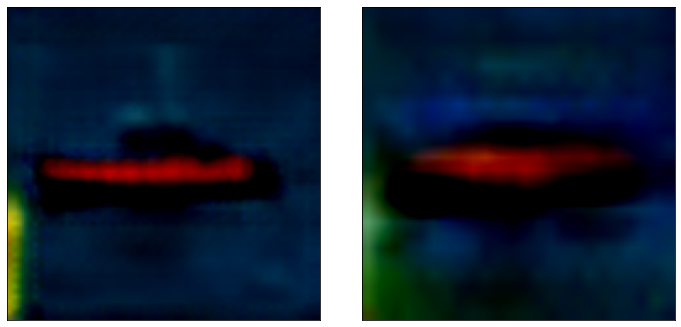





The MSE loss is:  0.0038937728386372328


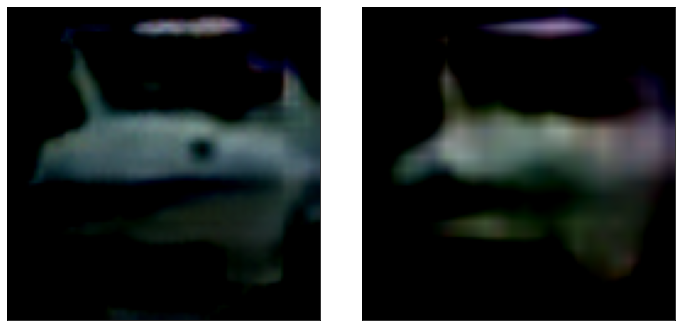





The MSE loss is:  0.011875434778630733


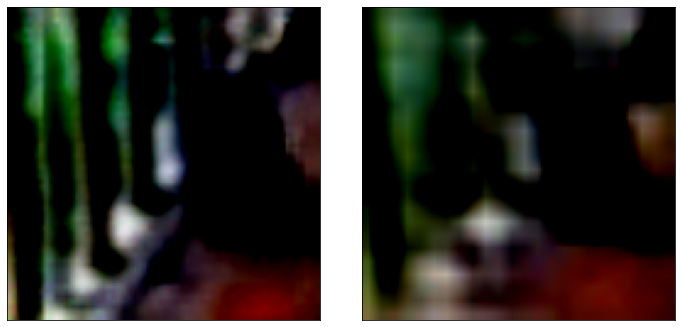





The MSE loss is:  0.00853103119879961


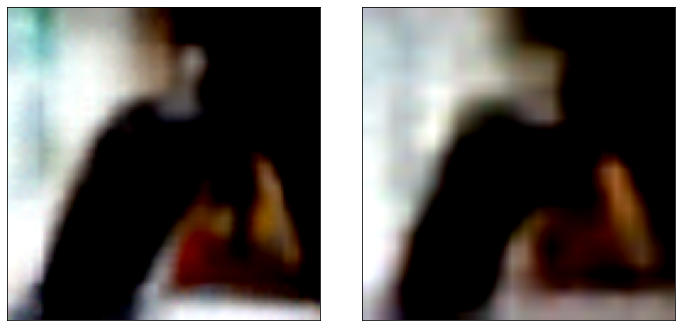





The MSE loss is:  0.009418392553925514


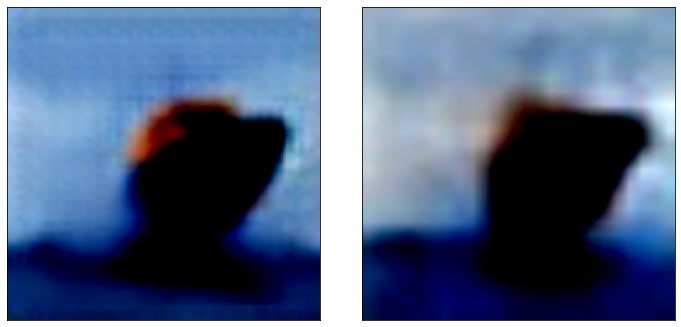





The MSE loss is:  0.010174766182899475


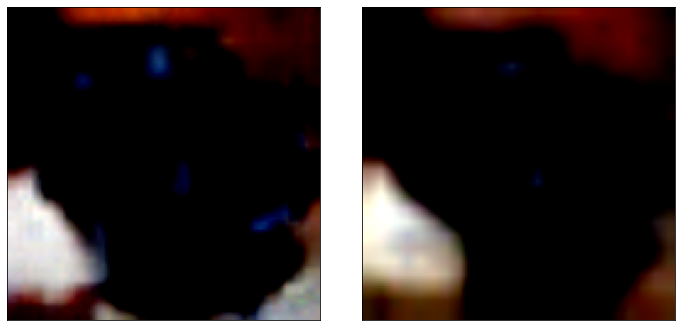





The MSE loss is:  0.007953339256346226


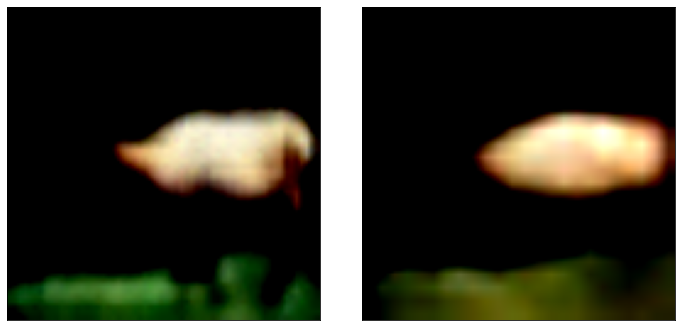





The MSE loss is:  0.007040421944111586


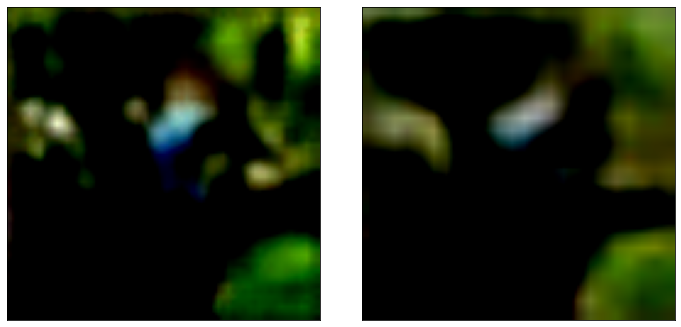





The MSE loss is:  0.004444787744432688


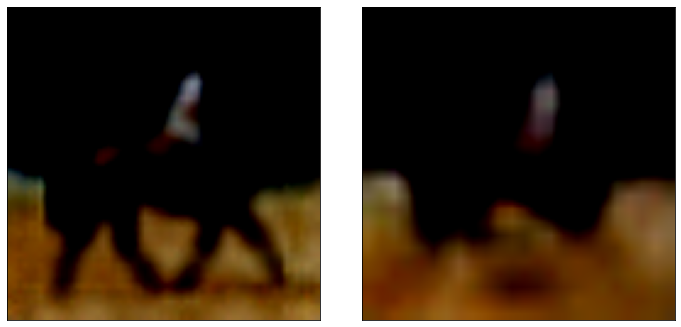





The MSE loss is:  0.0009622484794817865


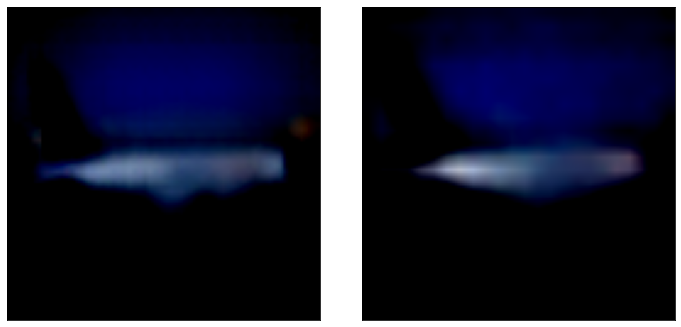





The MSE loss is:  0.002311678836122155


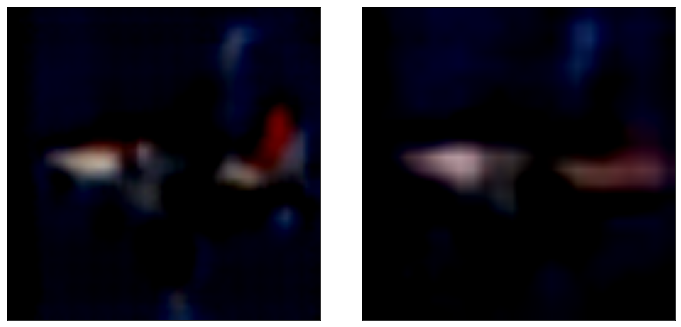





The MSE loss is:  0.01663939654827118


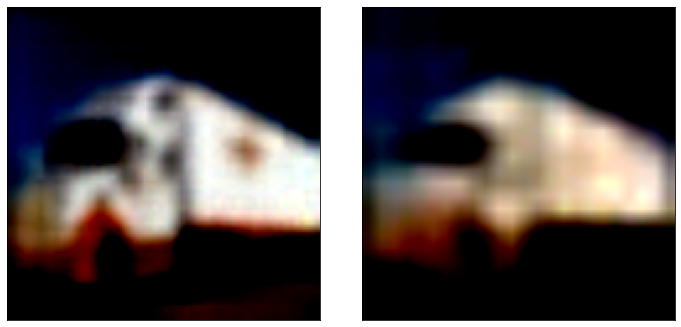





The MSE loss is:  0.0048538437113165855


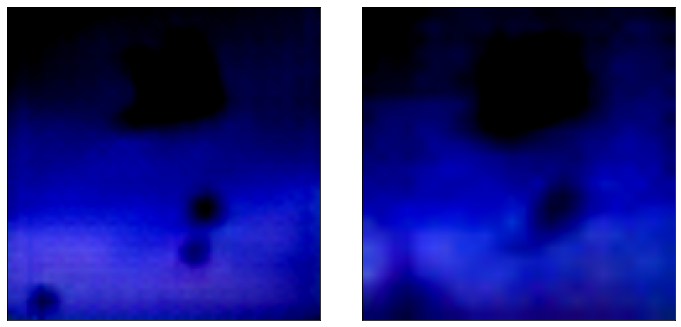





The MSE loss is:  0.006368966307491064


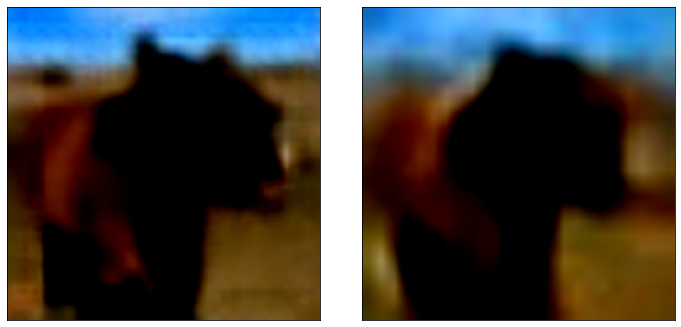





The MSE loss is:  0.005561754107475281


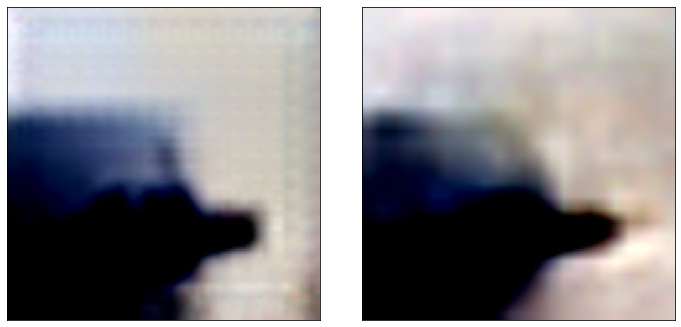





The MSE loss is:  0.00033184056519530714


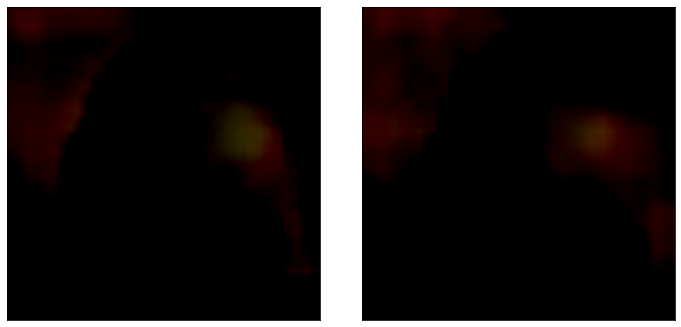





The MSE loss is:  0.003520835191011429


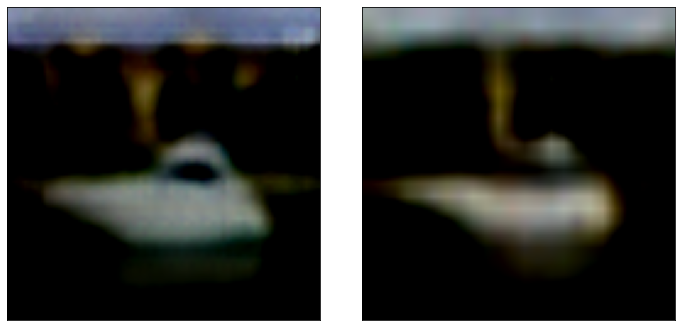





The MSE loss is:  0.003055083565413952


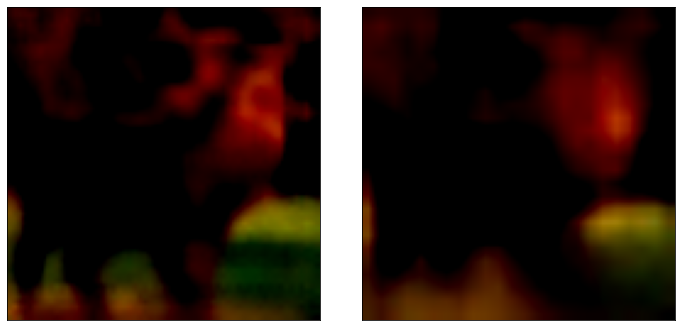





The MSE loss is:  0.004115833435207605


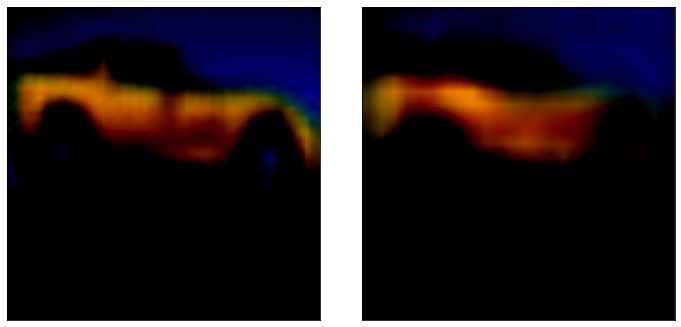





The MSE loss is:  0.005110482219606638


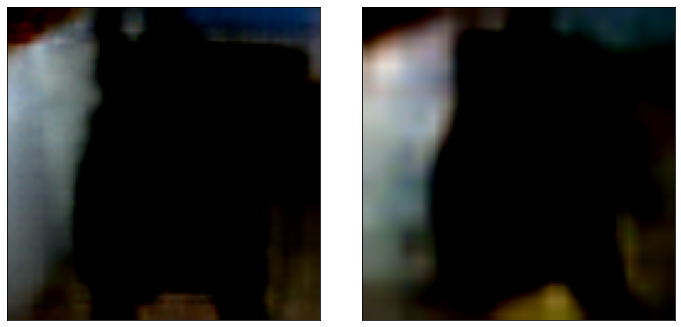





The MSE loss is:  1.7221655070898123e-06


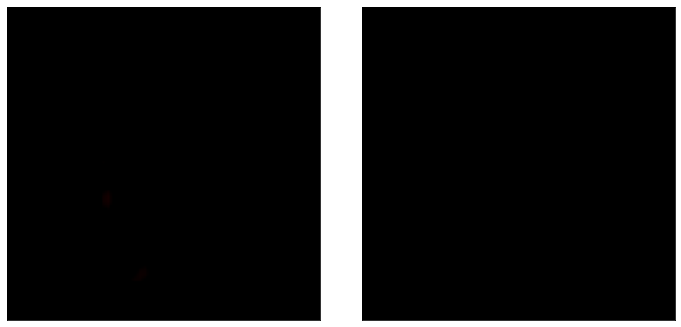

In [ ]:
# compare images + MSE of two models

vt.show_side_by_side_loss(im1 , im3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


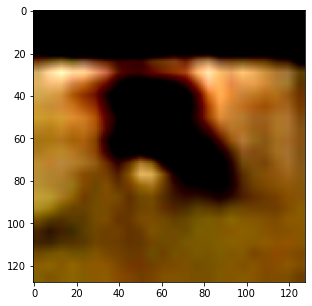

In [ ]:
# show 3 layered denoising model on gaussian noise

vt.show_image(im3[0], (5,5))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


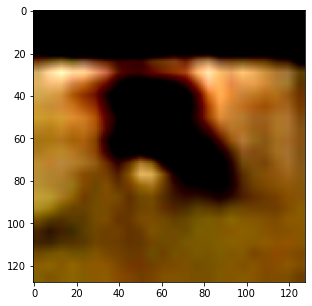

In [ ]:
# show 3 layered denoising model on speckle noise

vt.show_image(im4[0], (5,5))